# Analyse masked tif videos for tracked cell's mean pixel intensity

You can choose a channel and keep track of it while the recording progresses. 

Some plotting allows to identify the cell-tracking index for brightest cells.

Antoine

In [ ]:
%%time
import tifffile
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from scipy.ndimage import zoom
import os
import warnings
from matplotlib import cm

# === Config ===
original_path = "/pvc/scratch/interaction_cells/datasets/series003_cCAR_tumor.tif"
track_dir = "/pvc/scratch/SHARE/cancer_cell_masks/series003_cCAR_tumor_tracked"

# Channels to show (max 3); change these as needed
channels_to_display = [0, 1, 2]
channel_to_monitor = 1  # Channel used for brightness extraction

# === Load Data ===
original_stack = tifffile.imread(original_path)  # shape: (T, C, H, W)
track_files = sorted([f for f in os.listdir(track_dir) if f.endswith('.tif') and 'man_track' in f])
tracked_masks = np.array([tifffile.imread(os.path.join(track_dir, f)) for f in track_files])  # shape: (T, H, W)

# === Resize images to match masks ===
zoom_factors = (1, 1, 706 / 1412, 706 / 1412)
resized_original = zoom(original_stack, zoom_factors, order=1)

# === Normalize to [0, 1] per channel ===
norm_resized = np.zeros_like(resized_original, dtype=np.float32)
for c in range(resized_original.shape[1]):
    ch = resized_original[:, c]
    norm_resized[:, c] = (ch - ch.min()) / (ch.max() - ch.min() + 1e-8)

# === Data containers for analysis ===
trajectories = {}
brightness = {}


# === Set up plot ===
###plt.rcParams['animation.embed_limit'] = 50  # prevent large animation issues
plt.rcParams['animation.embed_limit'] = 100  # try go bigger

fig, axes = plt.subplots(1, 2, figsize=(14, 7))
img1 = axes[0].imshow(np.zeros((706, 706, 3)))
axes[0].set_title("Original Image")
axes[0].axis('off')

img2 = axes[1].imshow(np.zeros((706, 706, 3)))  # expects an image
axes[1].set_title(f"Tracked Mask + Channel {channel_to_monitor}")
axes[1].axis('off')

title = fig.suptitle("Frame 0")
label_texts = []

# === Animation update ===
def update(i):
    global label_texts
    for t in label_texts:
        t.remove()
    label_texts = []

    # Build multichannel frame
    selected_channels = norm_resized[i, channels_to_display]
    if selected_channels.shape[0] == 1:
        multichan_frame = np.repeat(selected_channels, 3, axis=0).transpose(1, 2, 0)
    elif selected_channels.shape[0] == 2:
        ch0, ch1 = selected_channels
        ch2 = np.zeros_like(ch0)
        multichan_frame = np.stack([ch0, ch1, ch2], axis=-1)
    else:
        multichan_frame = selected_channels[:3].transpose(1, 2, 0)

    img1.set_data(multichan_frame)

    # === Colorize mask by intensity ===
    img = norm_resized[i, channel_to_monitor]
    mask = tracked_masks[i]
    ids = np.unique(mask)
    ids = ids[ids != 0]

    color_mask = np.zeros((*mask.shape, 3), dtype=np.float32)

    for label_id in ids:
        yx = np.argwhere(mask == label_id)
        if len(yx) > 0:
            y_mean, x_mean = yx.mean(axis=0)

            # Trajectory collection
            trajectories.setdefault(label_id, []).append((x_mean, y_mean))

            # Brightness collection
            pixels = img[mask == label_id]
            mean_intensity = pixels.mean()
            brightness.setdefault(label_id, []).append(mean_intensity)

            # Color by brightness
            ###color = cm.viridis(np.clip(mean_intensity, 0, 1))[:3]
            color = cm.viridis(np.clip(mean_intensity / 0.05, 0, 1))[:3] # if 0.5 is typical max intensity

            color_mask[mask == label_id] = color

            # Label overlay
            txt = axes[1].text(x_mean, y_mean, str(label_id),
                               color='white', fontsize=8, ha='center', va='center',
                               bbox=dict(facecolor='black', alpha=0.5, edgecolor='none', pad=1))
            label_texts.append(txt)

    img2.set_data(color_mask)
    title.set_text(f"Frame {i}")
    return [img1, img2, title] + label_texts

# === Animate ===
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=UserWarning)
    anim = FuncAnimation(fig, update, frames=len(tracked_masks), interval=200, blit=False, repeat=False)

plt.close(fig) # just clear last static pic
HTML(anim.to_jshtml())

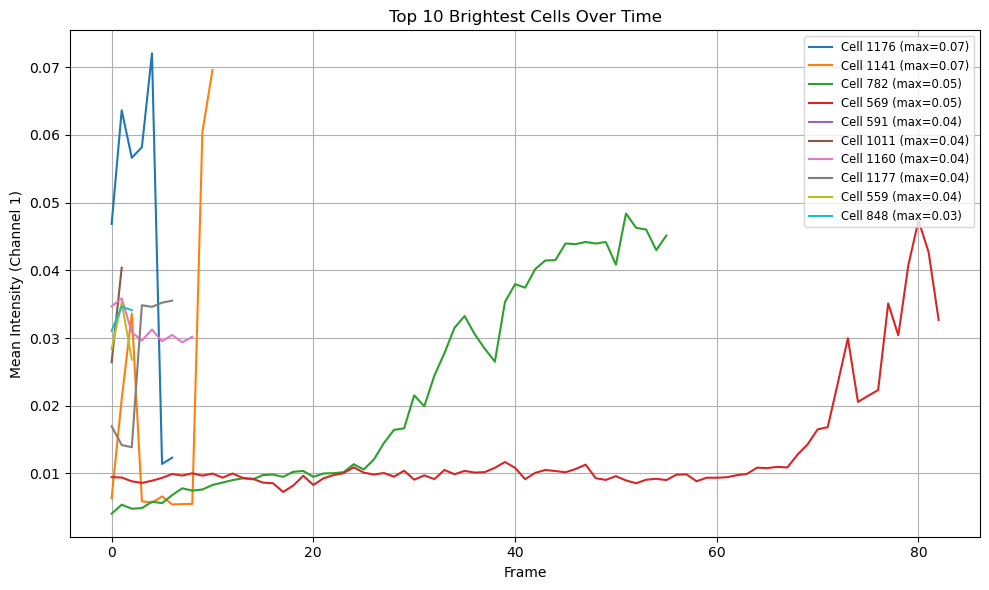

In [21]:
# Plot top cells based on brightness levels

top_n = 10

# Compute the max brightness reached by each cell
max_brightness = {cell_id: max(values) for cell_id, values in brightness.items()}

# Sort and select top N
top_cells = sorted(max_brightness, key=max_brightness.get, reverse=True)[:top_n]

# Plot
plt.figure(figsize=(10, 6))
for cell_id in top_cells:
    plt.plot(brightness[cell_id], label=f"Cell {cell_id} (max={max_brightness[cell_id]:.2f})")

plt.title(f"Top {top_n} Brightest Cells Over Time")
plt.xlabel("Frame")
plt.ylabel(f"Mean Intensity (Channel {channel_to_monitor})")
plt.legend(loc='upper right', fontsize='small')
plt.grid(True)
plt.tight_layout()
plt.show()


/tmp/ipykernel_128/854397442.py:12: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


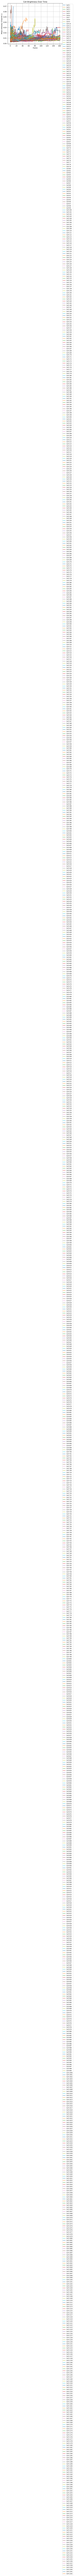

In [20]:
# Plot all brightness levels

import matplotlib.pyplot as plt

for cell_id, values in brightness.items():
    plt.plot(values, label=f"Cell {cell_id}")

plt.title("Cell Brightness Over Time")
plt.xlabel("Frame")
plt.ylabel(f"Mean Intensity (Channel {channel_to_monitor})")
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1.0), fontsize='small')
plt.grid(True)
plt.tight_layout()
plt.show()